In [33]:
import sys
sys.path.append('../libs')

from esnlib import *
from helpers import *
import pandas as pd

from sklearn import preprocessing
import sklearn.metrics as metrics

import sklearn.model_selection as ms
import matplotlib.pyplot as plt
import sklearn.metrics as sm

%matplotlib inline

In [34]:
def mape_score(y_test,y_pred):
    n = len(y_test)
    error = np.abs((y_test - y_pred)/np.mean(y_test))
    return np.sum(error)/n
    
def show_errors(y_test,y_pred):
    if type(y_test) is pd.DataFrame:
        y_test = y_test.values
    if type(y_pred) is pd.DataFrame:
        y_pred = y_pred.values
        
    n_metrics = 5
    metrics = np.zeros((n_metrics,13))
    for i in range(12):
        mae = sm.mean_absolute_error(y_test[:,i],y_pred[:,i])
        mse = sm.mean_squared_error(y_test[:,i],y_pred[:,i])
        medae = sm.median_absolute_error(y_test[:,i],y_pred[:,i])
        r2 = sm.r2_score(y_test[:,i],y_pred[:,i])
        mape = mape_score(y_test[:,i],y_pred[:,i])
        metrics[0,i] = mae
        metrics[1,i] = mse
        metrics[2,i] = medae
        metrics[3,i] = mape
        metrics[4,i] = r2
    for i in range(n_metrics):
        metrics[i,12] = np.mean(metrics[i,:12])
    
    metrics = pd.DataFrame(metrics)
    column_names = []
    for i in range(12):
        column_names.append("$t+{}$".format(i))
    column_names.append("$\overline{t+i}$")
    metrics.index = ["MAE","MSE", "MeAE", "MAPE" ,"$r^2$"]
    metrics.columns = column_names
    return metrics

In [11]:
data = pd.Series.from_csv('../../data/potency/canela1.csv')

input_steps = 24
prediction_steps = 12
train_perc = 0.8

X,y = getDataWindowed(data,input_steps,prediction_steps)

trainlen = int(train_perc*len(X))
X_train,X_test = X[:trainlen], X[trainlen:]
y_train,y_test = y[:trainlen], y[trainlen:]

In [12]:
minmax_in = preprocessing.MinMaxScaler(feature_range=(-1,1)) 
standarization_in = preprocessing.StandardScaler()
minmax_out = preprocessing.MinMaxScaler(feature_range=(-1,1)) 
standarization_out = preprocessing.StandardScaler()

minmax_in.fit(X_train)
minmax_out.fit(y_train)
standarization_in.fit(X_train)
standarization_out.fit(X_train)
preproc_in = minmax_in
preproc_out = minmax_out

In [13]:
X_train = preproc_in.transform(X_train) if preproc_in else X_train
X_test = preproc_in.transform(X_test) if preproc_in else X_test

y_train = preproc_out.transform(y_train) if preproc_out else y_train
y_test = preproc_out.transform(y_test) if preproc_out else y_test

In [19]:
def scorer(estimator, X,y):
    y_pred = estimator.predict(X,cont=True)
    return -metrics.mean_squared_error(y,y_pred)

n_splits = 5
tscv = ms.TimeSeriesSplit(n_splits=5)


#PARAMS
n_reservoir = 1000
sparsity = 0.9
leaking_rate = 0.3
regularization=1e-8
clf = ESN(random_state=42,n_reservoir=n_reservoir,sparsity=sparsity, 
          leaking_rate=leaking_rate,regularization=regularization)

In [20]:
score = ms.cross_val_score(clf,X_train,y_train, cv = tscv, n_jobs=-1,scoring=scorer)

In [25]:
clf.fit(X_train,y_train)

ESN(activation=<ufunc 'tanh'>, leaking_rate=0.3, n_inputs=24, n_outputs=12,
  n_reservoir=1000,
  random_state=<mtrand.RandomState object at 0x7f9cbae76678>,
  regularization=1e-08, sparsity=0.9, spectral_radius=0.135)

In [26]:
y_train_approx = clf.predict(X_train, cont=False)

In [27]:
y_test_approx = clf.predict(X_test,cont=True)

In [35]:
show_errors(y_train,y_train_approx)

,$t+0$,$t+1$,$t+2$,$t+3$,$t+4$,$t+5$,$t+6$,$t+7$,$t+8$,$t+9$,$t+10$,$t+11$,$\overline{t+i}$
MAE,0.121217,0.148239,0.169635,0.186610,0.200094,0.211206,0.220356,0.227737,0.233726,0.238522,0.242395,0.245805,0.203795
MSE,0.034698,0.048765,0.061376,0.071994,0.080738,0.088200,0.094352,0.099331,0.103284,0.106543,0.109160,0.111405,0.084154
MeAE,0.069249,0.089953,0.106937,0.121055,0.132982,0.142262,0.150972,0.158447,0.164599,0.168902,0.173266,0.176022,0.137887
MAPE,0.177780,0.217406,0.248780,0.273673,0.293446,0.309736,0.323149,0.333972,0.342752,0.349778,0.355452,0.360443,0.298864
$r^2$,0.788096,0.702179,0.625158,0.560308,0.506912,0.461338,0.423768,0.393362,0.369212,0.349283,0.333269,0.319514,0.486033


In [36]:
show_errors(y_test_approx , y_test)

,$t+0$,$t+1$,$t+2$,$t+3$,$t+4$,$t+5$,$t+6$,$t+7$,$t+8$,$t+9$,$t+10$,$t+11$,$\overline{t+i}$
MAE,0.125190,0.154469,0.175380,0.192913,0.207108,0.218493,0.227547,0.235292,0.242215,0.248031,0.252050,0.255772,0.211205
MSE,0.039190,0.055739,0.068350,0.079400,0.088600,0.095903,0.101400,0.106768,0.111733,0.115640,0.118444,0.120554,0.091810
MeAE,0.068049,0.090959,0.108611,0.124518,0.137192,0.147358,0.156683,0.164542,0.170903,0.176953,0.181194,0.183423,0.142532
MAPE,0.173895,0.215271,0.245188,0.270395,0.290895,0.307502,0.321015,0.332683,0.342835,0.351622,0.357544,0.363195,0.297670
$r^2$,0.631551,0.410213,0.184485,-0.054830,-0.300276,-0.544762,-0.776166,-1.006179,-1.216386,-1.392286,-1.518605,-1.634851,-0.601508


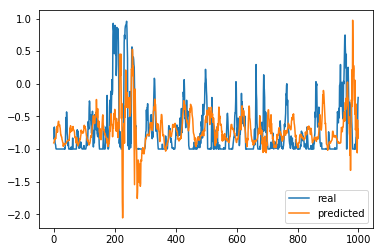

In [44]:
plt.plot(y_test[:1000,11],label="real")
plt.plot(y_test_approx[:1000,11],label="predicted")
plt.legend()

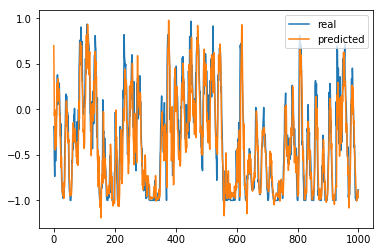

In [39]:
plt.plot(y_train[:1000,0],label="real")
plt.plot(y_train_approx[:1000,0],label="predicted")
plt.legend()